## Redes Neurais Artificiais 2024.1

- **Disciplina**: Redes Neurais Artificiais 2024.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta segunda parte do Projeto Prático 2.2 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos

### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão:

X_train_std = (X_train - np.mean(X_train))/np.std(X_train)

Em seguida, o mesmo deve ser feito com os atributos preditores do conjunto de testes, mas com padronização relativa ao conjunto de treinamento:

X_test_std = (X_test - np.mean(X_train))/np.std(X_train)

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.


### Continuando

5. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    5.1 Utilize a função de ativação ReLU  
    5.2 Utilize o solver Adam    
    5.3 Imprima o passo a passo do treinamento    
    5.4 Utilize o número máximo de épocas igual a 300  
6. Com o modelo em questão, após o treinamento, apresente:  
    6.1 Matriz de confusão para o conjunto de teste  
    6.2 Acurácia  
    6.3 F-Score  
    6.4 Precisão  
    6.5 Revocação  
7. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 10 vezes  
    7.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    7.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
8. Repita por 10 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    8.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Houve influência da escolha do otimizador no desempenho da rede?


In [ ]:
! pip show seaborn

Name: seaborn
Version: 0.13.1
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno


In [ ]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings

from prettytable import PrettyTable
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [ ]:
# Baixando o dataset para o diretório local
if not os.path.isfile('covtype.csv'):
  !kaggle datasets download -d uciml/forest-cover-type-dataset
  !unzip forest-cover-type-dataset.zip
  !rm *.zip

Dataset URL: https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset
License(s): unknown
 45% 5.00M/11.2M [00:00<00:00, 28.6MB/s]
100% 11.2M/11.2M [00:00<00:00, 52.4MB/s]
Archive:  forest-cover-type-dataset.zip
  inflating: covtype.csv             


In [ ]:
# Abertura da base de dados
df = pd.read_csv('covtype.csv')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
# Eliminando todas as colunas relativas aos atributos categóricos (wilderness areas e soil types)

filter_df = [col for col in df.columns if 'wilderness_area' not in col.lower() and 'soil_type' not in col.lower()]
df = df[filter_df]

display(df.columns)
print(f'\nQuantidade de colunas restantes após a exclusão de atributos categóricos: {df.shape[1]}')

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Cover_Type'],
      dtype='object')


Quantidade de colunas restantes após a exclusão de atributos categóricos: 11


In [ ]:
class Logger():
  def __init__(self, silence = False):
    self.__content: list[str] = []
    self.silence = silence

  def reset(self):
    self.content = []

  def add(self, output: str):
    if self.silence: return
    self.__content.append(output)

  def show(self):
    if self.silence: return
    for info in self.__content:
      print(info)

In [ ]:
from itertools import product

class AutoMLP:
  def __init__(self, params: dict[str, list] | list, X, y, holdout_size=.3, scale=True, n_random_archs=10, verbose=False, logger=Logger()):
    self.params = params
    self.estimators = []
    self.logger = logger
    self.n_random_archs = n_random_archs

    self.X = X
    self.y = y
    self.holdout_size = holdout_size
    self.scale = scale

    self.verbose = verbose

  def __scale(self, X_train, X_test):
    X_train_std = (X_train - np.mean(X_train))/np.std(X_train)
    X_test_std = (X_test - np.mean(X_train))/np.std(X_train)
    return X_train_std, X_test_std

  def __train_test_split(self):
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.holdout_size)
    if self.scale:
      X_train, X_test = self.__scale(X_train, X_test)
    return X_train, X_test, y_train, y_test

  def __generate_hidden_layer_sizes_possibilities(self, n_neurons, n_hidden_layers):
    tuples = product(range(1, n_neurons + 1), repeat=n_hidden_layers)
    distributions = [comb for comb in tuples if sum(comb) == n_neurons]
    return distributions

  def __select_n_random_architectures(self, n = 10):
    all_possibilities = []
    for n_neurons in self.params['n_neurons']:
      for n_hidden_layer in self.params['n_hidden_layer']:
        for max_epochs in self.params['max_epochs']:
          for solver in self.params['solver']:
            for layers_possibilities in self.__generate_hidden_layer_sizes_possibilities(n_neurons, n_hidden_layer):
              all_possibilities.append(dict(hidden_layer_sizes=layers_possibilities, max_iter=max_epochs, solver=solver))
    sorted_possibilities = np.random.choice(range(len(all_possibilities)), n)
    return [all_possibilities[index] for index in sorted_possibilities]

  def fit(self, rate = 1, shuffle = False, log_verbose = True):
    # Reiniciando a classe de logs
    self.logger.reset()

    # Gerando conjunto de treino e teste
    x_train, x_test, y_train, y_test = self.__train_test_split()

    if(type(self.params) == list):
      random_archs = self.params
    else:
      # Aleatoriamente escolhe 10 diferentes arquiteturas (com diferentes parâmetros) para realizar o treinamento
      random_archs = self.__select_n_random_architectures(self.n_random_archs)

    for arch in random_archs:
      self.logger.add(f"Treinando nova rede [hidden_layer_sizes = {arch['hidden_layer_sizes']}, max_epochs = {arch['max_iter']}, solver = {arch['solver']}]")
      for index in range(rate):
        mlp_neural_network = MLPClassifier(activation='relu',
                                          verbose=self.verbose,
                                           **arch)
        # Treinando
        warnings.simplefilter('ignore', category=ConvergenceWarning)
        mlp_neural_network.fit(x_train, y_train)

        # Calculando as métricas
        y_pred = mlp_neural_network.predict(x_test)
        f = f1_score(y_test, y_pred, average="weighted", zero_division=0.0)
        accuracy = accuracy_score(y_test, y_pred)

        self.logger.add(f"Iteração {index+1} [accuracy = {accuracy}, f1_score = {f}]")

        # Salvando métricas para futuro ranking
        self.estimators.append((mlp_neural_network, accuracy, f, [x_train, x_test, y_train, y_test, y_pred]))

        # Gerando novo holdout a cada iteração
        if shuffle:
          x_train, x_test, y_train, y_test = self.__train_test_split()

    if log_verbose:
      self.logger.show()

  def get_n_best_estimators(self,top = 3):
      self.estimators.sort(reverse=True,key = lambda estimator: (estimator[1], estimator[2]))
      best_estimators = self.estimators[:top].copy()
      return best_estimators


In [ ]:
# Armazenar o atributo alvo em uma variável y e os atributos preditores em uma variável X
y = df.Cover_Type
X = df.drop('Cover_Type', axis=1)

In [ ]:
params = {
  'hidden_layer_sizes': (10,),
  'solver': 'adam',
  'max_iter': 300
}

In [ ]:
# A classe AutoMLP fará o holdout 70/30 com o sklearn, e o escalonamento dos atributos
auto_mlp = AutoMLP(params=[params], X=X, y=y, holdout_size=0.30, scale=True, verbose=True)

# Treinando a rede com os parâmetros
auto_mlp.fit(log_verbose=False)

Iteration 1, loss = 1.26068949
Iteration 2, loss = 0.81547019
Iteration 3, loss = 0.76152336
Iteration 4, loss = 0.74581354
Iteration 5, loss = 0.74001385
Iteration 6, loss = 0.73618084
Iteration 7, loss = 0.73357775
Iteration 8, loss = 0.73181073
Iteration 9, loss = 0.72994249
Iteration 10, loss = 0.72875638
Iteration 11, loss = 0.72677305
Iteration 12, loss = 0.72513577
Iteration 13, loss = 0.72363234
Iteration 14, loss = 0.72207274
Iteration 15, loss = 0.72159788
Iteration 16, loss = 0.72072504
Iteration 17, loss = 0.72013289
Iteration 18, loss = 0.71947509
Iteration 19, loss = 0.71843775
Iteration 20, loss = 0.71868690
Iteration 21, loss = 0.71811341
Iteration 22, loss = 0.71756896
Iteration 23, loss = 0.71697313
Iteration 24, loss = 0.71782786
Iteration 25, loss = 0.71671672
Iteration 26, loss = 0.71625050
Iteration 27, loss = 0.71613877
Iteration 28, loss = 0.71544575
Iteration 29, loss = 0.71515928
Iteration 30, loss = 0.71491370
Iteration 31, loss = 0.71454315
Iteration 32, los

In [ ]:
# Matriz de confusão para o conjunto de teste

def show_metrics(y_test, prediction):

    # Matriz de Confusão
    cm = confusion_matrix(y_test, prediction)
    plt.figure(figsize=(10,8))
    plt.title('Matriz de confusão')
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
    plt.show()

    # Acurácia
    acc = accuracy_score(y_test, prediction)
    print(f"\nAcurácia: {acc}")

    # F1-Score
    f_score = f1_score(y_test, prediction, average='weighted')
    print(f"\nF-Score: {f_score}")

    # Precisão
    precision = precision_score(y_test, prediction, average='weighted')
    print(f"\nPrecisão: {precision}")

    # 6.5 Revocação
    recall = recall_score(y_test, prediction, average='weighted')
    print(f"\nRevocação: {recall}")

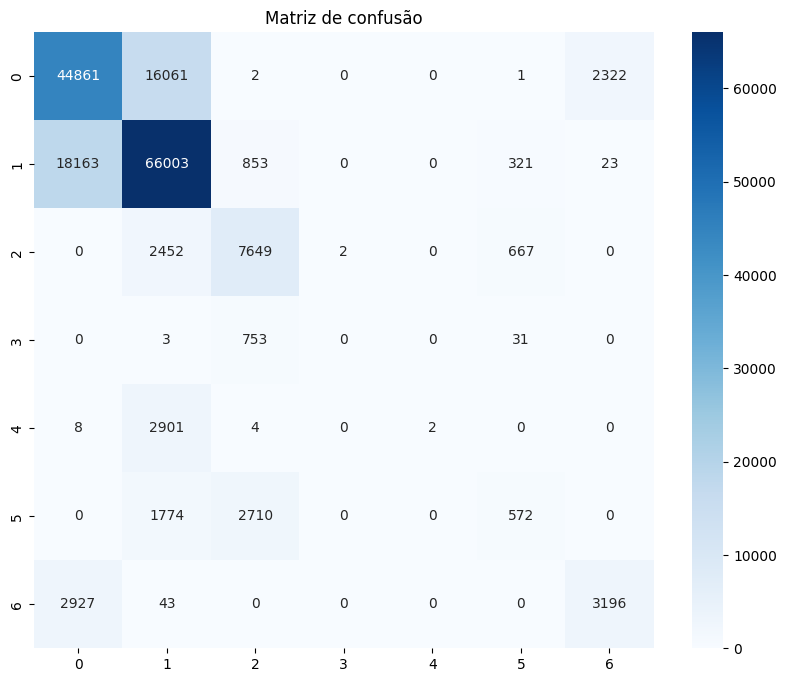


Acurácia: 0.7015501652285662

F-Score: 0.688128911781022

Precisão: 0.6960472860384955

Revocação: 0.7015501652285662


In [ ]:
_, _, _, y_test, y_pred  = auto_mlp.get_n_best_estimators(1)[0][3]
show_metrics(y_test, y_pred)

In [ ]:
def print_architectures(architectures):
    table = PrettyTable()
    table.field_names = ["hidden layer sizes", "max epochs", "solver", "Accuracy", "F1 Score"]
    table.title = f"Architectures Metrics"

    for arch in architectures:
      accuracy_list = []
      f1_list = []
      params = arch['params']
      for estimator in arch['output']:
        accuracy_list.append(estimator[1])
        f1_list.append(estimator[2])

      acc_mean = np.mean(accuracy_list)
      acc_std = np.std(accuracy_list)

      f1_mean = np.mean(f1_list)
      f1_std = np.std(f1_list)

      table.add_row([f"{params['hidden_layer_sizes']}", f"{params['max_iter']}", f"{params['solver']}", f"{'%.2f'%acc_mean} ± {'%.2f'%acc_std}", f"{'%.2f'%f1_mean} ± {'%.2f'%f1_std}"])
      # table.add_row(["", "", "", "", ""])

    print(table)

In [ ]:
# Repetindo o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 10 vezes

# A classe AutoMLP fará o holdout 70/30 com o sklearn, e o escalonamento dos atributos
auto_mlp = AutoMLP(params=[params], X=X, y=y, holdout_size=0.30, scale=True, verbose=False)
# Treinando a rede 10 vezes com shuffle=True para criar uma nova partição Holdout a cada execução
auto_mlp.fit(rate=10, shuffle=True, log_verbose=False)

# Média e desvio padrão da acurácia e do F-Score
print_architectures([dict(params=params, output=auto_mlp.estimators)])

+----------------------------------------------------------------------+
|                        Architectures Metrics                         |
+--------------------+------------+--------+-------------+-------------+
| hidden layer sizes | max epochs | solver |   Accuracy  |   F1 Score  |
+--------------------+------------+--------+-------------+-------------+
|       (10,)        |    300     |  adam  | 0.47 ± 0.17 | 0.40 ± 0.18 |
+--------------------+------------+--------+-------------+-------------+


In [ ]:
# Repetir por 10 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD
params = {
  'hidden_layer_sizes': (10,),
  'solver': 'sgd',
  'max_iter': 300
}

# A classe AutoMLP fará o holdout 70/30 com o sklearn, e o escalonamento dos atributos
auto_mlp = AutoMLP(params=[params], X=X, y=y, holdout_size=0.30, scale=True, verbose=False)
# Treinando a rede 10 vezes com shuffle=True para criar uma nova partição Holdout a cada execução
auto_mlp.fit(rate=10, shuffle=True, log_verbose=False)

# Média e desvio padrão da acurácia e do F-Score
print_architectures([dict(params=params, output=auto_mlp.estimators)])

+----------------------------------------------------------------------+
|                        Architectures Metrics                         |
+--------------------+------------+--------+-------------+-------------+
| hidden layer sizes | max epochs | solver |   Accuracy  |   F1 Score  |
+--------------------+------------+--------+-------------+-------------+
|       (10,)        |    300     |  sgd   | 0.51 ± 0.06 | 0.43 ± 0.08 |
+--------------------+------------+--------+-------------+-------------+


### Houve influência da escolha do otimizador no desempenho da rede?

Com o otimizador SGD, a rede teve um melhor desempenho, isso se deve ao fato de que o SGD é um bom otimizador para problemas de classificação binária ou multiclasse, especialmente quando se lida com grandes conjuntos de dados. Sua principal vantagem reside na velocidade de convergência, superando o Adam em muitos casos. Já o otimizador Adam, particularmente adequado para pequenos conjuntos de dados, utiliza estimativas adaptativas do primeiro e segundo momentos para atualizar os pesos da rede, resultando em uma convergência mais rápida para o mínimo global.

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe alientar também que você efetuou o treinamento desta rede por 10 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros apresentados por 100 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

#### Preparando as funções utilitárias e hiperparâmetros

In [ ]:
def print_best_estimators(top_estimators):
    table = PrettyTable()
    table.field_names = ["hidden layer sizes", "max epochs", "solver", "Accuracy", "F1 Score"]
    table.title = f"top {len(top_estimators)} estimator(s)"
    for estimator in top_estimators:
        params = estimator[0].get_params()
        table.add_row(
            [
                params["hidden_layer_sizes"],
                params["max_iter"],
                params["solver"],
                f"{'%.2f'%estimator[1]}",
                f"{'%.2f'%estimator[2]}",
            ]
        )
    print(table, end="\n\n")

In [ ]:
# Definindo parâmetros...
params = {
    'n_neurons': [10, 20, 30],
    'n_hidden_layer': [1, 2],
    'max_epochs': [100, 150, 200],
    'solver': ['adam', 'sgd']
}

In [ ]:
# a classe AutoMLP irá gerar as 10 arquiteturas aleatórias com base nas possibilidades da variável params
auto_mlp = AutoMLP(params=params, X=X, y=y, holdout_size=0.30, n_random_archs=10, scale=True)

# Treinando cada arquitetura por 100 vezes
auto_mlp.fit(rate=100)

In [ ]:
top_3_estimators = auto_mlp.get_n_best_estimators()
print_best_estimators(top_3_estimators)

In [ ]:
def print_classes(array):
  return ", ".join(str(i) for i in array)

def calculate_performance_measurement(estimators, x_test, y_test, title="Métricas dos Top 3 Modelos (para todas as classes)"):
  table = PrettyTable()
  table.title = title
  table.field_names = ['Rede', 'True Positive', 'True Negative', 'False Positive', 'False Negative']
  for estimator in estimators:
    nn = estimator[0]
    y_pred = nn.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    table.add_row([f'{nn}', print_classes(TP), print_classes(TN), print_classes(FP), print_classes(FN)])
  print(table)

In [ ]:
top_3_estimators = auto_mlp.get_n_best_estimators()
_, X_test_std, _, y_test, _  = top_3_estimators[0][3]

calculate_performance_measurement(top_3_estimators, X_test_std, y_test)

## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída.

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_o$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

In [ ]:
# Número de neurônios na camada de entrada e de saída
Ni = len(X.columns)
No = len(y.unique())

print(f"{Ni} neurônio[s] de entrada")
print(f"{No} neurônio[s] de saída")

In [ ]:
# Número de neurônios ocultos
Nh = []
for α in [0.5, 2 , 3]:
  Nh.append(int(np.round(α * np.sqrt(Ni * No))))

Nh

In [ ]:
# Definindo parâmetros...
params = {
    'n_neurons': Nh,
    'n_hidden_layer': [1, 2],
    'max_epochs': [100, 150, 200],
    'solver': ['adam', 'sgd']
}

In [ ]:
# Instanciândo MLP
auto_mlp = AutoMLP(params=params, X=X, y=y, holdout_size=0.30, n_random_archs=30, scale=True)

# Treinando cada arquitetura por 100 vezes
auto_mlp.fit(rate=100)

In [ ]:
# Imprimindo os melhores estimators
top_3_estimators_2 = auto_mlp.get_n_best_estimators()
print_best_estimators(top_3_estimators_2)

## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 10 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante as 10 repetições

In [ ]:
# Juntando as listas dos melhores estimators
top_6_estimators = top_3_estimators.copy()
top_6_estimators.extend(top_3_estimators_2)

# Salvando os hiperparâmetros dos melhores estimators
best_estimators = []
for estimator in top_6_estimators:
  parameters = estimator[0].get_params()
  # max_iter = 200 >> configurando para rodar por 200 épocas
  best_estimators.append(dict(hidden_layer_sizes=parameters["hidden_layer_sizes"], max_iter=200, solver=parameters["solver"]))

In [ ]:
results_list = []
# Iterando por todos os estimators
for params in best_estimators:
  # Instanciândo executando MLP
  auto_mlp = AutoMLP(params=[params], X=X, y=y, holdout_size=0.30, scale=False)
  auto_mlp.fit(rate=10)
  # Armazenando o resultado de Acurária e F1-score das 10 iterações de execução
  results_list.append(dict(params=params, output=auto_mlp.estimators, best_estimator=auto_mlp.get_n_best_estimators(1)))

In [ ]:
# Resultados com média e desvio padrão de acordo com cada arquitetura
print_architectures(results_list)

In [ ]:
# boxplot para o F-Score das 6 arquiteturas perante as 10 repetições

def plot_f_score(architectures):

  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 16))
  ax = axs.flatten()
  plt.suptitle("Boxplot dos F-score's", fontsize=24)
  current_index = 0

  for arch in architectures:
    f1_list = []
    for estimator in arch["output"]:
      f1_list.append(estimator[2])
    sns.boxplot(f1_list, ax=ax[current_index])
    ax[current_index].set_title(arch["params"], fontsize=10)
    ax[current_index].set_ylabel('')
    current_index += 1

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

In [ ]:
plot_f_score(results_list)

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?